*** A Decision Tree Regressor is required for the evaluation of the Sigh value for each US State. Provided is a Decision Model for a Solution Oriented way of finding Sigh Value equating towards the no. of deaths found in each state due to drug overdosage. ***

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.tree import export_graphviz

import pymysql
import lightgbm
import lightgbm.plotting

import seaborn

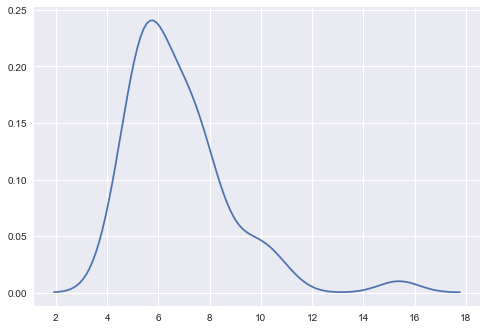

In [2]:
classifier = DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_split=12, 
                                   min_samples_leaf=1, max_features=3,
                                   max_leaf_nodes=23)

regressor = DecisionTreeRegressor(max_depth=2, min_samples_split=12, 
                                   min_samples_leaf=1, max_features=3,
                                   max_leaf_nodes=23)

states_integration = """
SELECT * FROM states_integration
"""

net_total_claim_count = 1258795672.00
net_total_30_day_fill_count = 1842106437.9756508

backup_connection = pymysql.connect(user='root', password='root',
                              host='localhost',
                              db='backup_table_metadata')

info_connection = pymysql.connect(user='root', password='root',
                                 host='localhost',
                                 db='drug_information')

cursor = backup_connection.cursor()

cursor.execute(states_integration)
states = cursor.fetchall()

cursor.close()

state_ptr = []
state_data = []
sigh = []
deaths = []
population = []
death_ratio = []

for state in states:
    deaths.append(state[4])
    population.append(state[5])
    death_ratio.append(state[2]*10000)
    
variance_deaths = np.var(deaths)

for state in states:
    state_data.append([state[2]*10000, state[4], state[5]])
    sigh.append((state[2]*10000)**2 + 0.5 * variance_deaths/100000)
    state_ptr.append(state[1])

classifier.fit(X=state_data, y=state_ptr)

regressor.fit(X=state_data, y=sigh)

seaborn.kdeplot(pd.Series(sigh))

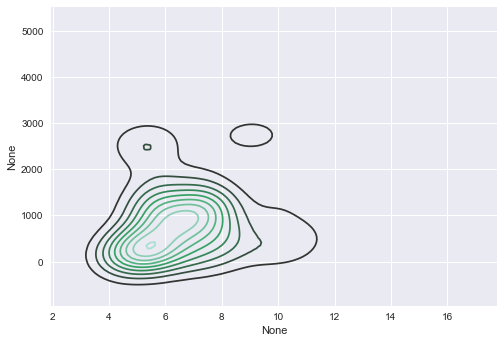

In [6]:
seaborn.kdeplot(pd.Series(sigh), pd.Series(deaths))

In [7]:
# Code sample from understanding decision path

n_nodes = classifier.tree_.node_count
children_left = classifier.tree_.children_left
children_right = classifier.tree_.children_right
feature = classifier.tree_.feature
threshold = classifier.tree_.threshold


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))

The binary tree structure has 15 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 0] <= 1.4905500412 else to node 2.
	node=1 test node: go to node 3 if X[:, 1] <= 519.5 else to node 4.
	node=2 test node: go to node 5 if X[:, 1] <= 750.0 else to node 6.
		node=3 test node: go to node 11 if X[:, 0] <= 1.12073993683 else to node 12.
		node=4 test node: go to node 7 if X[:, 0] <= 1.32588005066 else to node 8.
		node=5 test node: go to node 13 if X[:, 2] <= 1591303.0 else to node 14.
		node=6 test node: go to node 9 if X[:, 0] <= 1.8161149025 else to node 10.
			node=7 leaf node.
			node=8 leaf node.
			node=9 leaf node.
			node=10 leaf node.
			node=11 leaf node.
			node=12 leaf node.
			node=13 leaf node.
			node=14 leaf node.


### Decision Tree Classifier from Manual Selective Filtering

The decision tree provided here is referring to the decision model represented in this below grid.

Less Visibility | Greater Visibility
------------ | -------------
Evidence Based | Risk Aware
Reasoning | Risk Assessor

This decision tree classifier was produced from a solution oriented way such that we can equate the distribution of sigh values to the provided list of States and their corresponding position within the 4 Quadrants of a Decision Model.

#### Sliced_High_Max (death_ratio > 1.2 and 1000 < deaths < 3000)

**Row Labels**|**Sum of Population**|**Sum of Deaths**|**Sum of Ratio**
:-----:|:-----:|:-----:|:-----:
Kentucky|4395295|1077|2.450347474
Ohio|11570808|2744|2.371485207
Pennsylvania|12773801|2732|2.138752592
Tennessee|6495978|1269|1.953516468
Massachusetts|6692824|1289|1.925943369
Arizona|6626624|1211|1.827476555
Maryland|5928814|1070|1.804745435
Indiana|6570902|1172|1.783621183
Michigan|9895622|1762|1.780585394
Missouri|6044171|1067|1.765337215
New Jersey|8899339|1253|1.407969738
North Carolina|9848060|1358|1.378951794
Florida|19552860|2634|1.347117506
Illinois|12882135|1705|1.323538373
Georgia|9992167|1206|1.2069454

___________________________________________________________________

#### Sliced_High_Min (death_ratio > 1.2 and deaths < 1000)

**Row Labels**|**Sum of Population**|**Sum of Deaths**|**Sum of Ratio**
:-----:|:-----:|:-----:|:-----:
West Virginia|1854304|627|3.381322588
New Mexico|2085287|547|2.623140124
New Hampshire|1323459|334|2.523689816
Rhode Island|1051511|247|2.349000629
Utah|2900872|603|2.078685306
Delaware|925749|189|2.041590107
Oklahoma|3850568|777|2.017884115
Nevada|2790136|545|1.953309803
Wyoming|582658|109|1.870737208
Connecticut|3596080|623|1.732441992
Colorado|5268367|899|1.706411114
Alaska|735132|124|1.686771899
Louisiana|4625470|777|1.679829293
Maine|1328302|216|1.626136225
Alabama|4833722|723|1.495741791
Wisconsin|5742713|853|1.485360665
South Carolina|4774839|701|1.468112328
Washington|6971406|979|1.404307825
Oregon|3930065|522|1.328222307
Vermont|626630|83|1.324545585
Idaho|1612136|212|1.315025531
Montana|1015165|125|1.231326927
Arkansas|2959373|356|1.202957518

___________________________________________________________________

#### Sliced_Low_Max (death_ratio < 1.2 and population > 15000000)

**Row Labels**|**Sum of Population**|**Sum of Deaths**|**Sum of Ratio**
:-----:|:-----:|:-----:|:-----:
California|38332521|4521|1.179416298
New York|19651127|2300|1.170416333
Texas|26448193|2601|0.983432025

___________________________________________________________________

#### Sliced_Low_Min (death_ratio < 1.2 and population < 15000000)

**Row Labels**|**Sum of Population**|**Sum of Deaths**|**Sum of Ratio**
:-----:|:-----:|:-----:|:-----:
Virginia|8260405|980|1.186382508
Kansas|2893957|332|1.147218151
Mississippi|2991207|336|1.12329237
Hawaii|1404054|157|1.118190611
Minnesota|5420380|517|0.953807667
Iowa|3090416|264|0.854253926
South Dakota|844877|63|0.745670672
Nebraska|1868516|125|0.668980089
North Dakota|723393|43|0.594421013